In [1]:
import glob
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

import sklearn
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import classification_report 
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

import imblearn as imb
from imblearn.under_sampling import RandomUnderSampler

import scipy
import itertools
import random
import ast

## Data prep

In [2]:
data_dir = '/Users/kathleenkanaley/Desktop/grapes_from_space/data/img_scout_dfs'

# all three years
yearly_data = glob.glob(data_dir+'/*/smr_vis_skysat_scout_*.csv')
yearly_data



['/Users/kathleenkanaley/Desktop/grapes_from_space/data/img_scout_dfs/2022/smr_vis_skysat_scout_2022.csv',
 '/Users/kathleenkanaley/Desktop/grapes_from_space/data/img_scout_dfs/2021/smr_vis_skysat_scout_2021.csv',
 '/Users/kathleenkanaley/Desktop/grapes_from_space/data/img_scout_dfs/2020/smr_vis_skysat_scout_2020.csv']

In [3]:
prepped_dfs = []
for year in yearly_data:
    df = pd.read_csv(year)
    df = df.rename(columns={"green_red": "grvi"})
    # Create binary numeric label
    # 0 = low GDM
    # 1 = high GDM

    df['GDM_sev']=0
    df.loc[df['DM_severity'] > 10, 'GDM_sev'] =1
    
    df['GDM_inc']=0
    df.loc[df['DM_inc'] > 25, 'GDM_inc'] = 1
    prepped_dfs.append(df)

In [4]:
# Check columns
#prepped_dfs[0].columns
# prepped_dfs[0].Date.unique()
# prepped_dfs[1].Date.unique()
# prepped_dfs[2].Date.unique()

In [5]:
prepped_dfs[2].Date[1][:4]

'2020'

In [6]:
# set up variables
data_2022 = prepped_dfs[0]
data_2021 = prepped_dfs[1]
data_2020 = prepped_dfs[2]
data_all = pd.concat([data_2020,data_2021,data_2022])
sev = 'GDM_sev'
inc = 'GDM_inc'
vis = ['ndvi', 'evi','msavi', 'arvi', 'grvi']

## Find best set of VIs

In [7]:
def get_combinations(lst): # creating a user-defined method
    combination = [] # empty list 
    for r in range(1, len(lst) + 1):
      # to generate combination
      combination += itertools.combinations(lst, r)
    return combination

In [8]:
all_combinations = get_combinations(vis) # method call
print(all_combinations)

[('ndvi',), ('evi',), ('msavi',), ('arvi',), ('grvi',), ('ndvi', 'evi'), ('ndvi', 'msavi'), ('ndvi', 'arvi'), ('ndvi', 'grvi'), ('evi', 'msavi'), ('evi', 'arvi'), ('evi', 'grvi'), ('msavi', 'arvi'), ('msavi', 'grvi'), ('arvi', 'grvi'), ('ndvi', 'evi', 'msavi'), ('ndvi', 'evi', 'arvi'), ('ndvi', 'evi', 'grvi'), ('ndvi', 'msavi', 'arvi'), ('ndvi', 'msavi', 'grvi'), ('ndvi', 'arvi', 'grvi'), ('evi', 'msavi', 'arvi'), ('evi', 'msavi', 'grvi'), ('evi', 'arvi', 'grvi'), ('msavi', 'arvi', 'grvi'), ('ndvi', 'evi', 'msavi', 'arvi'), ('ndvi', 'evi', 'msavi', 'grvi'), ('ndvi', 'evi', 'arvi', 'grvi'), ('ndvi', 'msavi', 'arvi', 'grvi'), ('evi', 'msavi', 'arvi', 'grvi'), ('ndvi', 'evi', 'msavi', 'arvi', 'grvi')]


In [9]:
# Append all possible combinations of vis to the spectral bands
# Result = list of potential explanatory variables

exp_vars = []
for combo in all_combinations:
    combo = list(combo)
    sb = ['blue', 'green', 'red', 'nir']
    sb_plus_vi = sb + combo
    exp_vars.append(sb_plus_vi)
#exp_vars

In [10]:
# Prep the dataset: balance the data and scale
## no need to split into train/test

def data_prep(data, expl_vars, resp_var, state, seed):
    X = data[expl_vars]
    y = data[resp_var]

    rus = RandomUnderSampler(random_state=state)
    X_rus, y_rus = rus.fit_resample(X, y)

    mm = MinMaxScaler()
    X_scaled = mm.fit_transform(X_rus)
    
    return X_scaled, y_rus #features (scaled) and labels (unscaled)

In [11]:
# Get a dictionary of models for each set of explanatory variables

def get_models(explanatory_vars):
    models = dict()
    for i in exp_vars:
        model = RandomForestClassifier()
        models[str(i)] = model
    return models

In [12]:
# evaluate a given model using cross-validation

def evaluate_model(model, X, y,scoring):
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1) # will get 30 (10x3) different results
    scores = cross_val_score(model, X, y, scoring=scoring, cv=cv, n_jobs=-1, error_score='raise')
    return scores

In [13]:
def F1_df(df, models, resp_var):
    results = pd.DataFrame(columns=['name','F1', 'features'])
    F1 = []
    features = []
    year = []
    for name, model in models.items():
        X,y = data_prep(df,ast.literal_eval(name),resp_var,2024,16)
        scores = evaluate_model(model, X, y,'f1')
        F1.append(np.mean(scores))
        features.append(name)
        year.append(df.Date[0][:4])

    results['name'] = year
    results['F1']=F1
    results['features']=features
    
    return results

In [14]:
# get dataframes of average F1 scores for models with different combinations of explanatory variables
models = get_models(exp_vars)

F1_dfs = []

for df in [data_2020, data_2021, data_2022]:
    F1_scores = F1_df(df, models, 'GDM_sev')
    F1_dfs.append(F1_scores)

len(F1_dfs)

3

In [15]:
F1_dfs[0].name

0     2020
1     2020
2     2020
3     2020
4     2020
5     2020
6     2020
7     2020
8     2020
9     2020
10    2020
11    2020
12    2020
13    2020
14    2020
15    2020
16    2020
17    2020
18    2020
19    2020
20    2020
21    2020
22    2020
23    2020
24    2020
25    2020
26    2020
27    2020
28    2020
29    2020
30    2020
Name: name, dtype: object

In [16]:
# best vi combos for each year (maximizes F1)
combo_20 = F1_dfs[0].iloc[F1_dfs[0]['F1'].idxmax()]['features']
print("Best feature combo for 2020:", combo_20)

combo_21 = F1_dfs[1].iloc[F1_dfs[1]['F1'].idxmax()]['features']
print("Best feature combo for 2021:", combo_21)

combo_22 = F1_dfs[2].iloc[F1_dfs[2]['F1'].idxmax()]['features']
print("Best feature combo for 2022:", combo_22)

Best feature combo for 2020: ['blue', 'green', 'red', 'nir', 'ndvi']
Best feature combo for 2021: ['blue', 'green', 'red', 'nir', 'evi', 'grvi']
Best feature combo for 2022: ['blue', 'green', 'red', 'nir', 'grvi']


## Balance, split, normalize

In [17]:
def bal_split_norm(data, expl_vars, resp_var, state, seed):
    X = data[expl_vars]
    y = data[resp_var]

    rus = RandomUnderSampler(random_state=state)
    X_rus, y_rus = rus.fit_resample(X, y)

    # Split dataset into training set and test set
    X_train, X_test, y_train, y_test = train_test_split(X_rus, y_rus,
                                                        test_size=0.3, 
                                                        random_state=seed,
                                                        stratify = y_rus)  # 70% training and 30% test
    mm = MinMaxScaler()
    X_train_scaled = mm.fit_transform(X_train)
    X_test_scaled = mm.transform(X_test)
    
    return X_train_scaled, y_train, X_test_scaled, y_test

## For 2020

In [18]:
# X_train, y_train, X_test, y_test = bal_split_norm(data_2020,
#                                                   ast.literal_eval(combo_20), #convert string to list
#                                                  sev,
#                                                  2020,
#                                                  14)

## Hyperparameter tuning (training set only)

In [19]:
# # Create dictionary of parameters to test with randomizedCV

# from sklearn.model_selection import RandomizedSearchCV

# n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1000,
# num = 10)]
# max_features = ['log2', 'sqrt']
# max_depth = [int(x) for x in np.linspace(start = 1, stop = 15, num =
# 15)]
# min_samples_split = [int(x) for x in np.linspace(start = 2, stop = 50,
# num = 10)]
# min_samples_leaf = [int(x) for x in np.linspace(start = 1, stop = 50,
# num = 5)]
# bootstrap = [True, False]
# param_dist = {'n_estimators': n_estimators,
# 'max_features': max_features,
# 'max_depth': max_depth,
# 'min_samples_split': min_samples_split,
# 'min_samples_leaf': min_samples_leaf,
# 'bootstrap': bootstrap}

In [20]:
# rfc = RandomForestClassifier()

In [21]:
# rs = RandomizedSearchCV(rfc,
# param_dist,
# n_iter = 100,
# scoring = 'f1',
# cv = 3,
# verbose = 1,
# n_jobs=-1,
# random_state=0)

# rs.fit(X_train, y_train)
# rs.best_params_

Fitting 3 folds for each of 100 candidates, totalling 300 fits


{'n_estimators': 200,
 'min_samples_split': 12,
 'min_samples_leaf': 1,
 'max_features': 'log2',
 'max_depth': 7,
 'bootstrap': True}

In [22]:
# rs_df = pd.DataFrame(rs.cv_results_).sort_values('rank_test_score').reset_index(drop=True)
# rs_df = rs_df.drop([
# 'mean_fit_time',
# 'std_fit_time',
# 'mean_score_time',
# 'std_score_time',
# 'params',
# 'split0_test_score',
# 'split1_test_score',
# 'split2_test_score',
# 'std_test_score'],
# axis=1)

# rs_df.head(10)

,param_n_estimators,param_min_samples_split,param_min_samples_leaf,param_max_features,param_max_depth,param_bootstrap,mean_test_score,rank_test_score
0,200,12,1,log2,7,True,0.702020,1
1,600,12,1,log2,4,False,0.697691,2
2,300,18,1,sqrt,12,False,0.659596,3
3,300,12,1,log2,13,False,0.658009,4
4,700,2,1,log2,6,False,0.643357,5
5,400,23,1,log2,5,False,0.596633,6
6,400,23,1,log2,3,False,0.596633,6
7,700,18,1,log2,7,True,0.590572,8
8,1000,50,1,sqrt,8,True,0.210526,9
9,800,39,37,sqrt,8,True,0.210526,9


In [23]:
# from sklearn.model_selection import GridSearchCV
# n_estimators = [100,200,300,600]
# max_features = ['sqrt','log2']
# max_depth = [3,4,7,12,13]
# min_samples_split = [2,12,18]
# min_samples_leaf = [1,37]
# bootstrap = [True,False]

# param_grid = {'n_estimators': n_estimators,
# 'max_features': max_features,
# 'max_depth': max_depth,
# 'min_samples_split': min_samples_split,
# 'min_samples_leaf': min_samples_leaf,
# 'bootstrap': bootstrap}

# gs = GridSearchCV(rfc, param_grid, cv = 3, verbose = 1, n_jobs=-1)
# gs.fit(X_train, y_train)
# rfc_2 = gs.best_estimator_
# gs.best_params_

Fitting 3 folds for each of 480 candidates, totalling 1440 fits


{'bootstrap': True,
 'max_depth': 3,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 300}

In [24]:
# y_pred_gs = rfc_2.predict(X_test)

## Plot confusion matrix and get all model metrics

[[6 2]
 [3 6]]
              precision    recall  f1-score   support

           0       0.67      0.75      0.71         8
           1       0.75      0.67      0.71         9

    accuracy                           0.71        17
   macro avg       0.71      0.71      0.71        17
weighted avg       0.71      0.71      0.71        17



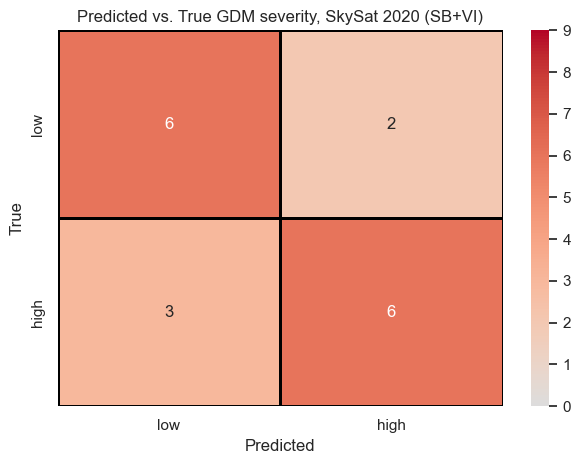

In [25]:
# from sklearn.metrics import confusion_matrix                            



# cf_matrix = confusion_matrix(y_test, y_pred_gs)
# print(cf_matrix)

# sns.set(font_scale=1)
# sns.heatmap(cf_matrix, annot=True,
#            vmin=0, vmax=9, center= 0,
#            cmap= 'coolwarm', linewidths=2, linecolor='black',
#            xticklabels=['low','high'],
#            yticklabels=['low','high']).set(title='Predicted vs. True GDM severity, SkySat 2020 (SB+VI)');

# plt.ylabel('True')
# plt.xlabel('Predicted')
# plt.tight_layout()

# plt.savefig('/Users/kathleenkanaley/Desktop/figs_phytopath_rev/corr_matrices_RF/SkySat/SB+VI/Sev_2020.jpg')
# report = classification_report(y_test, y_pred_gs)

# print(report)
# # conf_matrix_tuned = pd.DataFrame(confusion_matrix(y_test, y_pred_gs),
# #         index = [np.unique(y_pred)[0],np.unique(y_pred)[1]], columns = [np.unique(y_pred)[0],np.unique(y_pred)[1]])
                                                         
# # display(conf_matrix_tuned)
# # display('Hyperparameter Tuned Random Forest accuracy score', accuracy_score(y_test, y_pred_gs))

In [83]:
# # Make sure axes are properly labeled
# unique, counts = np.unique(y_pred_gs, return_counts=True)

# dict(zip(unique, counts))

{0: 28, 1: 43}

## Permutation importance plots

In [84]:
# Get permutation feature imp. scores
# https://scikit-learn.org/stable/auto_examples/inspection/plot_permutation_importance.html#sphx-glr-auto-examples-inspection-plot-permutation-importance-py

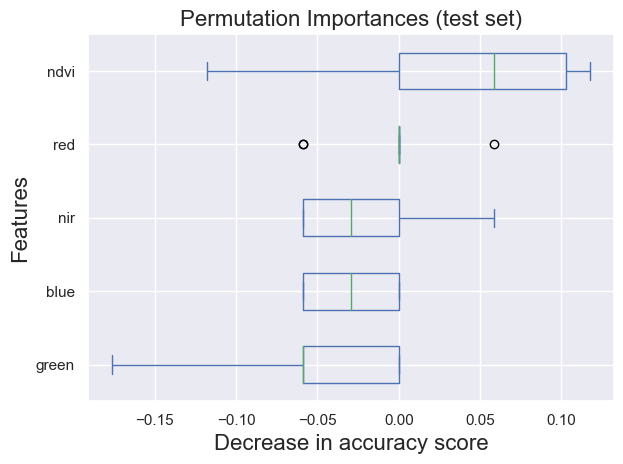

In [26]:
# from sklearn.inspection import permutation_importance

# result = permutation_importance(
#     rfc_2, X_test, y_test, n_repeats=10, random_state=16, n_jobs=2
# )

# sorted_importances_idx = result.importances_mean.argsort()

# importances = pd.DataFrame(
#     result.importances[sorted_importances_idx].T,
#     columns=data_2020[ast.literal_eval(combo_20)].columns[sorted_importances_idx],
# )
# ax = importances.plot.box(vert=False, whis=10)
# ax.set_title("Permutation Importances (test set)",fontname="Arial", fontsize=16)
# #ax.axvline(x=0, color="k", linestyle="--")
# ax.set_xlabel("Decrease in accuracy score",fontname="Arial", fontsize = 16)
# ax.set_ylabel("Features",fontname="Arial", fontsize = 16)

# ax.figure.tight_layout()
# plt.savefig('/Users/kathleenkanaley/Desktop/figs_phytopath_rev/permimp_RF/SkySat/SB+VI/permimp_sev20.jpg')

## 2021

In [27]:
# X_train, y_train, X_test, y_test = bal_split_norm(data_2021,
#                                                   ast.literal_eval(combo_21), #convert string to list
#                                                  sev,
#                                                  2020,
#                                                  14)

In [28]:
# # Create dictionary of parameters to test with randomizedCV

# from sklearn.model_selection import RandomizedSearchCV

# n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1000,
# num = 10)]
# max_features = ['log2', 'sqrt']
# max_depth = [int(x) for x in np.linspace(start = 1, stop = 15, num =
# 15)]
# min_samples_split = [int(x) for x in np.linspace(start = 2, stop = 50,
# num = 10)]
# min_samples_leaf = [int(x) for x in np.linspace(start = 1, stop = 50,
# num = 5)]
# bootstrap = [True, False]
# param_dist = {'n_estimators': n_estimators,
# 'max_features': max_features,
# 'max_depth': max_depth,
# 'min_samples_split': min_samples_split,
# 'min_samples_leaf': min_samples_leaf,
# 'bootstrap': bootstrap}

In [29]:
# rfc = RandomForestClassifier()
# rs = RandomizedSearchCV(rfc,
# param_dist,
# n_iter = 100,
# scoring = 'f1',
# cv = 3,
# verbose = 1,
# n_jobs=-1,
# random_state=0)

# rs.fit(X_train, y_train)
# rs.best_params_

Fitting 3 folds for each of 100 candidates, totalling 300 fits


{'n_estimators': 200,
 'min_samples_split': 12,
 'min_samples_leaf': 1,
 'max_features': 'log2',
 'max_depth': 7,
 'bootstrap': True}

In [30]:
# rs_df = pd.DataFrame(rs.cv_results_).sort_values('rank_test_score').reset_index(drop=True)
# rs_df = rs_df.drop([
# 'mean_fit_time',
# 'std_fit_time',
# 'mean_score_time',
# 'std_score_time',
# 'params',
# 'split0_test_score',
# 'split1_test_score',
# 'split2_test_score',
# 'std_test_score'],
# axis=1)

# rs_df.head(10)

,param_n_estimators,param_min_samples_split,param_min_samples_leaf,param_max_features,param_max_depth,param_bootstrap,mean_test_score,rank_test_score
0,200,12,1,log2,7,True,0.701149,1
1,700,2,1,log2,6,False,0.697336,2
2,300,12,1,log2,13,False,0.693563,3
3,600,12,1,log2,4,False,0.691710,4
4,700,18,1,log2,7,True,0.691575,5
5,300,18,1,sqrt,12,False,0.690626,6
6,600,7,13,log2,1,False,0.690159,7
7,700,23,25,log2,1,False,0.686212,8
8,700,28,1,sqrt,8,False,0.683332,9
9,900,50,1,log2,3,False,0.681061,10


In [31]:
# from sklearn.model_selection import GridSearchCV
# n_estimators = [100,200,300,600,700]
# max_features = ['sqrt','log2']
# max_depth = [3,4,6,7,13]
# min_samples_split = [2,12,18]
# min_samples_leaf = [1,13]
# bootstrap = [True,False]

# param_grid = {'n_estimators': n_estimators,
# 'max_features': max_features,
# 'max_depth': max_depth,
# 'min_samples_split': min_samples_split,
# 'min_samples_leaf': min_samples_leaf,
# 'bootstrap': bootstrap}

# gs = GridSearchCV(rfc, param_grid, cv = 3, verbose = 1, n_jobs=-1)
# gs.fit(X_train, y_train)
# rfc_2 = gs.best_estimator_
# gs.best_params_

Fitting 3 folds for each of 600 candidates, totalling 1800 fits


{'bootstrap': True,
 'max_depth': 4,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 100}

In [32]:
# y_pred_gs = rfc_2.predict(X_test)

[[24 12]
 [11 26]]
              precision    recall  f1-score   support

           0       0.69      0.67      0.68        36
           1       0.68      0.70      0.69        37

    accuracy                           0.68        73
   macro avg       0.68      0.68      0.68        73
weighted avg       0.68      0.68      0.68        73



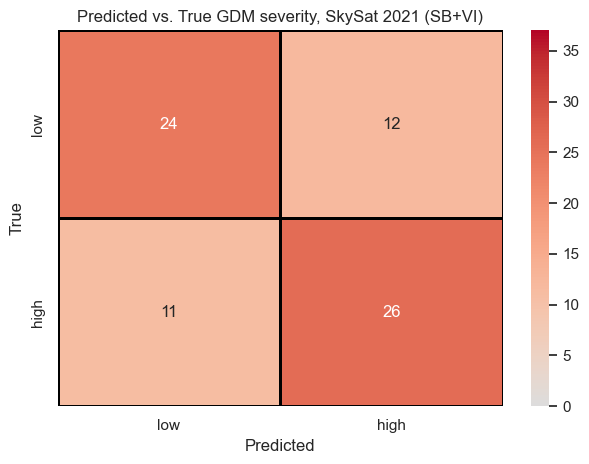

In [33]:
# from sklearn.metrics import confusion_matrix                            


# cf_matrix = confusion_matrix(y_test, y_pred_gs)
# print(cf_matrix)

# sns.set(font_scale=1)
# sns.heatmap(cf_matrix, annot=True, fmt='.3g',
#            vmin=0, vmax=37, center= 0,
#            cmap= 'coolwarm', linewidths=2, linecolor='black',
#            xticklabels=['low','high'],
#            yticklabels=['low','high']).set(title='Predicted vs. True GDM severity, SkySat 2021 (SB+VI)');

# plt.ylabel('True')
# plt.xlabel('Predicted')
# plt.tight_layout()

# plt.savefig('/Users/kathleenkanaley/Desktop/figs_phytopath_rev/corr_matrices_RF/SkySat/SB+VI/Sev_2021.jpg')
# report = classification_report(y_test, y_pred_gs)

# print(report)
# # conf_matrix_tuned = pd.DataFrame(confusion_matrix(y_test, y_pred_gs),
# #         index = [np.unique(y_pred)[0],np.unique(y_pred)[1]], columns = [np.unique(y_pred)[0],np.unique(y_pred)[1]])
                                                         
# # display(conf_matrix_tuned)
# # display('Hyperparameter Tuned Random Forest accuracy score', accuracy_score(y_test, y_pred_gs))

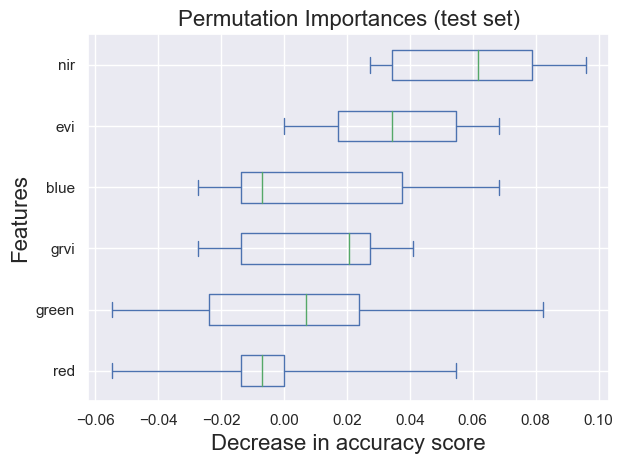

In [34]:
# from sklearn.inspection import permutation_importance

# result = permutation_importance(
#     rfc_2, X_test, y_test, n_repeats=10, random_state=16, n_jobs=2
# )

# sorted_importances_idx = result.importances_mean.argsort()

# importances = pd.DataFrame(
#     result.importances[sorted_importances_idx].T,
#     columns=data_2021[ast.literal_eval(combo_21)].columns[sorted_importances_idx],
# )
# ax = importances.plot.box(vert=False, whis=10)
# ax.set_title("Permutation Importances (test set)",fontname="Arial", fontsize=16)
# #ax.axvline(x=0, color="k", linestyle="--")
# ax.set_xlabel("Decrease in accuracy score",fontname="Arial", fontsize = 16)
# ax.set_ylabel("Features",fontname="Arial", fontsize = 16)

# ax.figure.tight_layout()
# plt.savefig('/Users/kathleenkanaley/Desktop/figs_phytopath_rev/permimp_RF/SkySat/SB+VI/permimp_sev21.jpg')

## 2022

In [35]:
# X_train, y_train, X_test, y_test = bal_split_norm(data_2022,
#                                                   ast.literal_eval(combo_22), #convert string to list
#                                                  sev,
#                                                  2020,
#                                                  14)

In [36]:
# # Create dictionary of parameters to test with randomizedCV

# from sklearn.model_selection import RandomizedSearchCV

# n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1000,
# num = 10)]
# max_features = ['log2', 'sqrt']
# max_depth = [int(x) for x in np.linspace(start = 1, stop = 15, num =
# 15)]
# min_samples_split = [int(x) for x in np.linspace(start = 2, stop = 50,
# num = 10)]
# min_samples_leaf = [int(x) for x in np.linspace(start = 1, stop = 50,
# num = 5)]
# bootstrap = [True, False]
# param_dist = {'n_estimators': n_estimators,
# 'max_features': max_features,
# 'max_depth': max_depth,
# 'min_samples_split': min_samples_split,
# 'min_samples_leaf': min_samples_leaf,
# 'bootstrap': bootstrap}

In [37]:
# rfc = RandomForestClassifier()
# rs = RandomizedSearchCV(rfc,
# param_dist,
# n_iter = 100,
# scoring = 'f1',
# cv = 3,
# verbose = 1,
# n_jobs=-1,
# random_state=0)

# rs.fit(X_train, y_train)
# rs.best_params_

Fitting 3 folds for each of 100 candidates, totalling 300 fits


{'n_estimators': 700,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'log2',
 'max_depth': 6,
 'bootstrap': False}

In [38]:
# rs_df = pd.DataFrame(rs.cv_results_).sort_values('rank_test_score').reset_index(drop=True)
# rs_df = rs_df.drop([
# 'mean_fit_time',
# 'std_fit_time',
# 'mean_score_time',
# 'std_score_time',
# 'params',
# 'split0_test_score',
# 'split1_test_score',
# 'split2_test_score',
# 'std_test_score'],
# axis=1)

# rs_df.head(10)

,param_n_estimators,param_min_samples_split,param_min_samples_leaf,param_max_features,param_max_depth,param_bootstrap,mean_test_score,rank_test_score
0,700,2,1,log2,6,False,0.500000,1
1,300,18,25,sqrt,3,True,0.412698,2
2,800,12,13,sqrt,15,True,0.412698,2
3,700,7,25,log2,7,True,0.412698,2
4,300,12,13,log2,12,True,0.412698,2
5,300,39,1,log2,6,True,0.412698,2
6,200,28,37,sqrt,5,True,0.412698,2
7,800,39,37,sqrt,8,True,0.412698,2
8,700,39,13,sqrt,13,True,0.412698,2
9,700,50,50,log2,3,True,0.412698,2


In [39]:
# from sklearn.model_selection import GridSearchCV
# n_estimators = [100,300,700,800]
# max_features = ['sqrt','log2']
# max_depth = [3,6,7,15]
# min_samples_split = [2,7,12,18]
# min_samples_leaf = [1,13,25]
# bootstrap = [True,False]

# param_grid = {'n_estimators': n_estimators,
# 'max_features': max_features,
# 'max_depth': max_depth,
# 'min_samples_split': min_samples_split,
# 'min_samples_leaf': min_samples_leaf,
# 'bootstrap': bootstrap}

# gs = GridSearchCV(rfc, param_grid, cv = 3, verbose = 1, n_jobs=-1)
# gs.fit(X_train, y_train)
# rfc_2 = gs.best_estimator_
# gs.best_params_

Fitting 3 folds for each of 768 candidates, totalling 2304 fits


{'bootstrap': False,
 'max_depth': 3,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 7,
 'n_estimators': 100}

In [40]:
# y_pred_gs = rfc_2.predict(X_test)

[[2 1]
 [2 1]]
              precision    recall  f1-score   support

           0       0.50      0.67      0.57         3
           1       0.50      0.33      0.40         3

    accuracy                           0.50         6
   macro avg       0.50      0.50      0.49         6
weighted avg       0.50      0.50      0.49         6



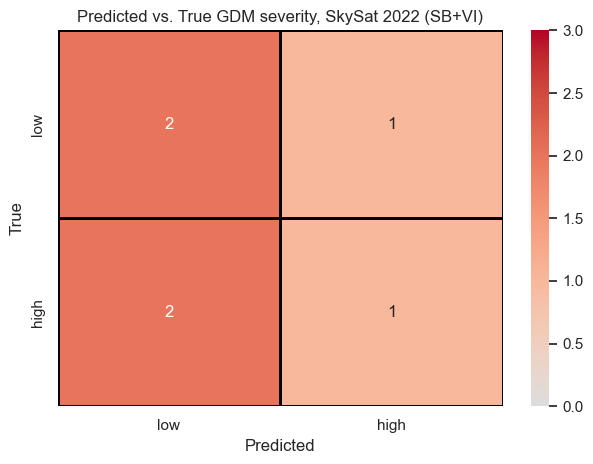

In [41]:
# from sklearn.metrics import confusion_matrix                            


# cf_matrix = confusion_matrix(y_test, y_pred_gs)
# print(cf_matrix)

# sns.set(font_scale=1)
# sns.heatmap(cf_matrix, annot=True, fmt='.3g',
#            vmin=0, vmax=3, center= 0,
#            cmap= 'coolwarm', linewidths=2, linecolor='black', 
#            #cbar_kws={'ticks':[0,1,2,3]},
#            xticklabels=['low','high'],
#            yticklabels=['low','high']).set(title='Predicted vs. True GDM severity, SkySat 2022 (SB+VI)');

# plt.ylabel('True')
# plt.xlabel('Predicted')
# plt.tight_layout()

# plt.savefig('/Users/kathleenkanaley/Desktop/figs_phytopath_rev/corr_matrices_RF/SkySat/SB+VI/Sev_2022.jpg')
# report = classification_report(y_test, y_pred_gs)

# print(report)
# # conf_matrix_tuned = pd.DataFrame(confusion_matrix(y_test, y_pred_gs),
# #         index = [np.unique(y_pred)[0],np.unique(y_pred)[1]], columns = [np.unique(y_pred)[0],np.unique(y_pred)[1]])
                                                         
# # display(conf_matrix_tuned)
# # display('Hyperparameter Tuned Random Forest accuracy score', accuracy_score(y_test, y_pred_gs))

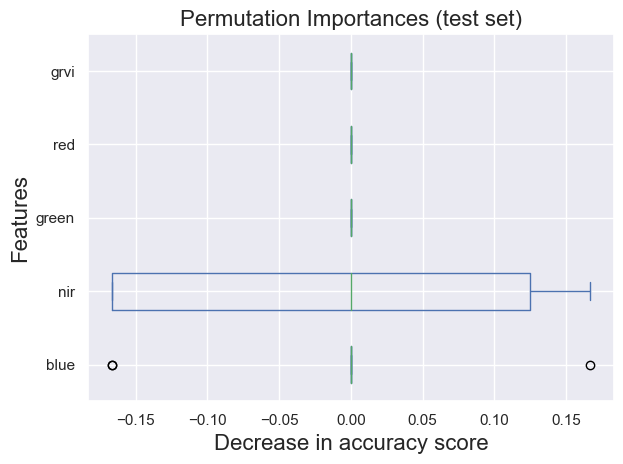

In [42]:
# from sklearn.inspection import permutation_importance

# result = permutation_importance(
#     rfc_2, X_test, y_test, n_repeats=10, random_state=16, n_jobs=2
# )

# sorted_importances_idx = result.importances_mean.argsort()

# importances = pd.DataFrame(
#     result.importances[sorted_importances_idx].T,
#     columns=data_2022[ast.literal_eval(combo_22)].columns[sorted_importances_idx],
# )
# ax = importances.plot.box(vert=False, whis=10)
# ax.set_title("Permutation Importances (test set)",fontname="Arial", fontsize=16)
# #ax.axvline(x=0, color="k", linestyle="--")
# ax.set_xlabel("Decrease in accuracy score",fontname="Arial", fontsize = 16)
# ax.set_ylabel("Features",fontname="Arial", fontsize = 16)

# ax.figure.tight_layout()
# plt.savefig('/Users/kathleenkanaley/Desktop/figs_phytopath_rev/permimp_RF/SkySat/SB+VI/permimp_sev22.jpg')

## All years

In [43]:
# get F1 scores for different VI combos

models = get_models(exp_vars)

F1_allyear = pd.DataFrame(columns=['F1', 'features'])
F1 = []
features = []

for name, model in models.items():
        X,y = data_prep(data_all,ast.literal_eval(name),sev,2024,16)
        scores = evaluate_model(model, X, y,'f1')
        F1.append(np.mean(scores))
        features.append(name)
F1_allyear['F1']=F1
F1_allyear['features']=features

F1_allyear

,F1,features
0,0.753211,"['blue', 'green', 'red', 'nir', 'ndvi']"
1,0.737168,"['blue', 'green', 'red', 'nir', 'evi']"
2,0.732458,"['blue', 'green', 'red', 'nir', 'msavi']"
3,0.740982,"['blue', 'green', 'red', 'nir', 'arvi']"
4,0.742042,"['blue', 'green', 'red', 'nir', 'grvi']"
5,0.738616,"['blue', 'green', 'red', 'nir', 'ndvi', 'evi']"
6,0.735867,"['blue', 'green', 'red', 'nir', 'ndvi', 'msavi']"
7,0.747654,"['blue', 'green', 'red', 'nir', 'ndvi', 'arvi']"
8,0.751569,"['blue', 'green', 'red', 'nir', 'ndvi', 'grvi']"
9,0.749819,"['blue', 'green', 'red', 'nir', 'evi', 'msavi']"


In [44]:
# find VI combo that maximizes F1

combo_all = F1_allyear.iloc[F1_allyear['F1'].idxmax()]['features']
print("Best feature combo for all-year:", combo_all)

Best feature combo for all-year: ['blue', 'green', 'red', 'nir', 'arvi', 'grvi']


In [45]:
X_train, y_train, X_test, y_test = bal_split_norm(data_all,
                                                  ast.literal_eval(combo_all), #convert string to list
                                                 sev,
                                                 2020,
                                                 14)

In [46]:
# Create dictionary of parameters to test with randomizedCV

from sklearn.model_selection import RandomizedSearchCV

n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1000,
num = 10)]
max_features = ['log2', 'sqrt']
max_depth = [int(x) for x in np.linspace(start = 1, stop = 15, num =
15)]
min_samples_split = [int(x) for x in np.linspace(start = 2, stop = 50,
num = 10)]
min_samples_leaf = [int(x) for x in np.linspace(start = 1, stop = 50,
num = 5)]
bootstrap = [True, False]
param_dist = {'n_estimators': n_estimators,
'max_features': max_features,
'max_depth': max_depth,
'min_samples_split': min_samples_split,
'min_samples_leaf': min_samples_leaf,
'bootstrap': bootstrap}

In [47]:
rfc = RandomForestClassifier()
rs = RandomizedSearchCV(rfc,
param_dist,
n_iter = 100,
scoring = 'f1',
cv = 3,
verbose = 1,
n_jobs=-1,
random_state=0)

rs.fit(X_train, y_train)
rs.best_params_

Fitting 3 folds for each of 100 candidates, totalling 300 fits


{'n_estimators': 700,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'log2',
 'max_depth': 6,
 'bootstrap': False}

In [48]:
rs_df = pd.DataFrame(rs.cv_results_).sort_values('rank_test_score').reset_index(drop=True)
rs_df = rs_df.drop([
'mean_fit_time',
'std_fit_time',
'mean_score_time',
'std_score_time',
'params',
'split0_test_score',
'split1_test_score',
'split2_test_score',
'std_test_score'],
axis=1)

rs_df.head(10)

,param_n_estimators,param_min_samples_split,param_min_samples_leaf,param_max_features,param_max_depth,param_bootstrap,mean_test_score,rank_test_score
0,700,2,1,log2,6,False,0.773312,1
1,600,12,1,log2,4,False,0.765517,2
2,300,18,1,sqrt,12,False,0.760926,3
3,300,12,1,log2,13,False,0.757778,4
4,400,23,1,log2,5,False,0.751871,5
5,200,12,1,log2,7,True,0.741107,6
6,700,18,1,log2,7,True,0.726902,7
7,400,23,1,log2,3,False,0.724014,8
8,1000,50,1,sqrt,8,True,0.723974,9
9,700,28,1,sqrt,8,False,0.720082,10


In [49]:
from sklearn.model_selection import GridSearchCV
n_estimators = [100,300,600,700]
max_features = ['sqrt','log2']
max_depth = [3,4,6,12,13]
min_samples_split = [2,12,18,23]
min_samples_leaf = [1]
bootstrap = [True,False]

param_grid = {'n_estimators': n_estimators,
'max_features': max_features,
'max_depth': max_depth,
'min_samples_split': min_samples_split,
'min_samples_leaf': min_samples_leaf,
'bootstrap': bootstrap}

gs = GridSearchCV(rfc, param_grid, cv = 3, verbose = 1, n_jobs=-1)
gs.fit(X_train, y_train)
rfc_2 = gs.best_estimator_
gs.best_params_

Fitting 3 folds for each of 320 candidates, totalling 960 fits


{'bootstrap': False,
 'max_depth': 13,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 18,
 'n_estimators': 100}

In [50]:
y_pred_gs = rfc_2.predict(X_test)

[[36 11]
 [18 30]]
              precision    recall  f1-score   support

           0       0.67      0.77      0.71        47
           1       0.73      0.62      0.67        48

    accuracy                           0.69        95
   macro avg       0.70      0.70      0.69        95
weighted avg       0.70      0.69      0.69        95



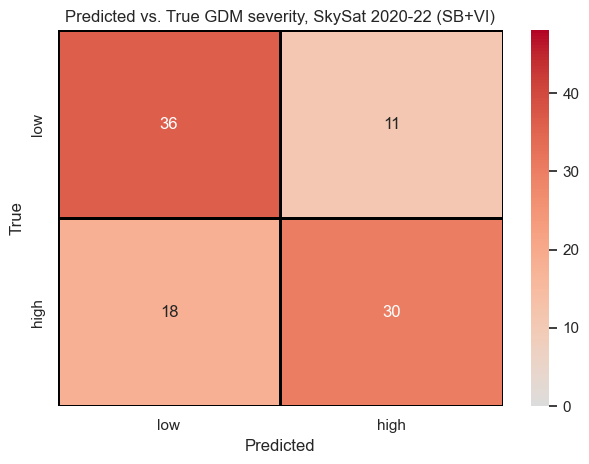

In [52]:
from sklearn.metrics import confusion_matrix                            


cf_matrix = confusion_matrix(y_test, y_pred_gs)
print(cf_matrix)

sns.set(font_scale=1)
sns.heatmap(cf_matrix, annot=True, fmt='.3g',
           vmin=0, vmax=48, center= 0,
           cmap= 'coolwarm', linewidths=2, linecolor='black',
           xticklabels=['low','high'],
           yticklabels=['low','high']).set(title='Predicted vs. True GDM severity, SkySat 2020-22 (SB+VI)');

plt.ylabel('True')
plt.xlabel('Predicted')
plt.tight_layout()

plt.savefig('/Users/kathleenkanaley/Desktop/figs_phytopath_rev/corr_matrices_RF/SkySat/SB+VI/Sev_all.jpg')
report = classification_report(y_test, y_pred_gs)

print(report)
# conf_matrix_tuned = pd.DataFrame(confusion_matrix(y_test, y_pred_gs),
#         index = [np.unique(y_pred)[0],np.unique(y_pred)[1]], columns = [np.unique(y_pred)[0],np.unique(y_pred)[1]])
                                                         
# display(conf_matrix_tuned)
# display('Hyperparameter Tuned Random Forest accuracy score', accuracy_score(y_test, y_pred_gs))

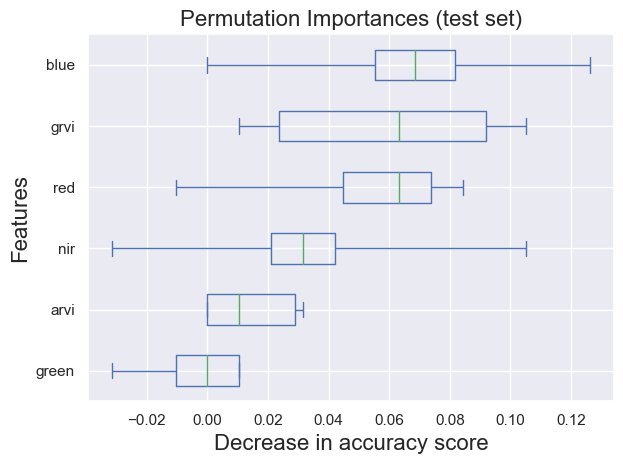

In [53]:
from sklearn.inspection import permutation_importance

result = permutation_importance(
    rfc_2, X_test, y_test, n_repeats=10, random_state=16, n_jobs=2
)

sorted_importances_idx = result.importances_mean.argsort()

importances = pd.DataFrame(
    result.importances[sorted_importances_idx].T,
    columns=data_all[ast.literal_eval(combo_all)].columns[sorted_importances_idx],
)
ax = importances.plot.box(vert=False, whis=10)
ax.set_title("Permutation Importances (test set)",fontname="Arial", fontsize=16)
#ax.axvline(x=0, color="k", linestyle="--")
ax.set_xlabel("Decrease in accuracy score",fontname="Arial", fontsize = 16)
ax.set_ylabel("Features",fontname="Arial", fontsize = 16)

ax.figure.tight_layout()
plt.savefig('/Users/kathleenkanaley/Desktop/figs_phytopath_rev/permimp_RF/SkySat/SB+VI/permimp_sevall.jpg')